In [9]:
#abcd

In [10]:
from PIL import Image

In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import os
import cv2
#import skimage.io as io
#import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
# Input data files are available in the read-only "../input/" directory
import os
import matplotlib.pyplot as plt

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [13]:
!kaggle datasets download -d vbookshelf/rice-leaf-diseases

 74% 27.0M/36.7M [00:00<00:00, 144MB/s] 
100% 36.7M/36.7M [00:00<00:00, 132MB/s]


In [14]:
! unzip rice-leaf-diseases.zip

Archive:  rice-leaf-diseases.zip
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0365.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0366.jpg  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0367.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0370.jpg  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0372.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0373.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0374.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0375.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0376.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0377.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0378.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0379.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0380.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0381.JPG  
 

In [15]:
import tensorflow as tf


In [16]:
os.listdir('/content/rice_leaf_diseases')

['Leaf smut', 'Bacterial leaf blight', 'Brown spot']

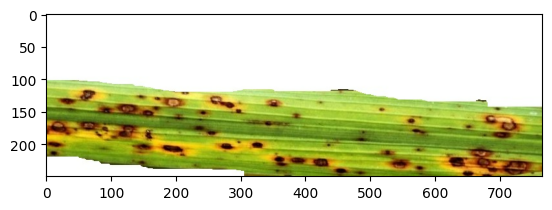

In [17]:
im = tf.io.read_file('/content/rice_leaf_diseases/Brown spot/DSC_0100.jpg')
im = tf.io.decode_jpeg(im)
plt.imshow(im)

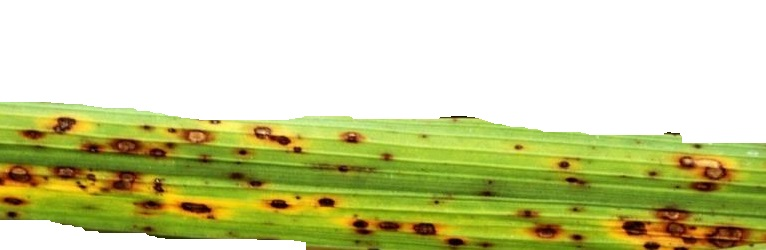

In [18]:
Image.open('/content/rice_leaf_diseases/Brown spot/DSC_0100.jpg')

In [19]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [20]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [21]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [22]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

In [23]:
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [24]:
im.shape

TensorShape([250, 766, 3])

In [25]:
import matplotlib.image as mpimg

In [27]:
resize = True
size = 2
folder_count = 3
main = '/content/rice_leaf_diseases'
total_sample_size = len(os.listdir('/content/rice_leaf_diseases/Bacterial leaf blight')) + len(os.listdir('/content/rice_leaf_diseases/Brown spot')) + len(os.listdir('/content/rice_leaf_diseases/Leaf smut'))

In [32]:
main + '/' + os.listdir(main)[0] + '/' +os.listdir(main + '/' + os.listdir(main)[0])[0]

'/content/rice_leaf_diseases/Leaf smut/DSC_0335.JPG'

In [51]:
from PIL import Image
import numpy as np

def resize_image_to_array(input_path):
    try:
        # Open the image file
        with Image.open(input_path) as img:
            # Resize the image to the specified dimensions
            resized_img = img.resize((228, 228), resample=Image.ANTIALIAS)
            # Convert the resized image to a NumPy array
            img_array = np.array(resized_img)
            img_array = np.array(resized_img.convert('L'))
            return img_array
    except Exception as e:
        print(f"Error: {e}")
        return None

In [80]:
def get_data(size, total_sample_size):
    #read the image
    image = mpimg.imread('/content/rice_leaf_diseases/Bacterial leaf blight/DSC_0366.jpg', 'rw+')
    #reduce the size
    if resize == True:
        image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0

    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, 228 , 228])

    y_genuine = np.zeros([total_sample_size,1])

    for i in range(folder_count):
        for j in range(20):
            ind1 = 0
            ind2 = 0

            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(20)
                ind2 = np.random.randint(20)

            # read the two images
            img1 = resize_image_to_array(main + '/' + os.listdir(main)[i] + '/' + os.listdir(main + '/' + os.listdir(main)[i])[ind1])
            img2 = resize_image_to_array(main + '/' + os.listdir(main)[i] + '/' + os.listdir(main + '/' + os.listdir(main)[i])[ind2])

            #reduce the size
            if resize == True:
                img1 = img1[::, ::]
                img2 = img2[::, ::]

            #store the images to the initialized numpy arrayprint
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2

            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, 228, 228])
    y_imposite = np.zeros([total_sample_size, 1])

    for i in range(int(total_sample_size/20)):
        for j in range(20):

            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(folder_count)
                ind2 = np.random.randint(folder_count)
                if ind1 != ind2:
                    break

            img1 = resize_image_to_array(main + '/' + os.listdir(main)[ind1] + '/' + os.listdir(main + '/' + os.listdir(main)[ind1])[j])
            img2 = resize_image_to_array(main + '/' + os.listdir(main)[ind2] + '/' + os.listdir(main + '/' + os.listdir(main)[ind2])[j])

            if resize == True:
                img1 = img1[::, ::]
                img2 = img2[::, ::]

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1

    #now, concatenate, genuine pairs and imposite pair to get the whole data
    #print(x_geuine_pair.shape)
    #print(x_imposite_pair.shape)
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y
X, Y = get_data(size, total_sample_size)

<ipython-input-51-420708fcdee8>:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((228, 228), resample=Image.ANTIALIAS)


In [54]:
X.shape

(240, 2, 1, 114, 114)

In [55]:
Y.shape

(240, 1)

In [62]:
np.unique(Y)

array([0., 1.])

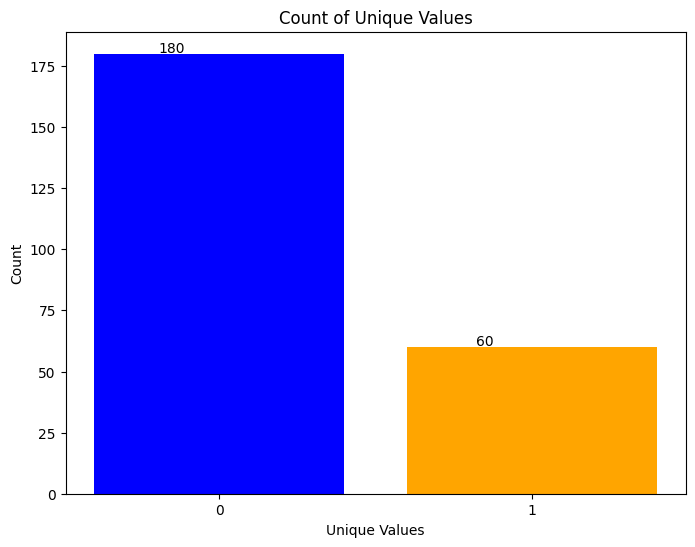

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
unique_values, counts = np.unique(Y, return_counts=True)

# Create a bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(unique_values, counts ,  color=['blue', 'orange'])
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.5, str(count), ha='center')
plt.xticks(unique_values)
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Count of Unique Values')
plt.show()

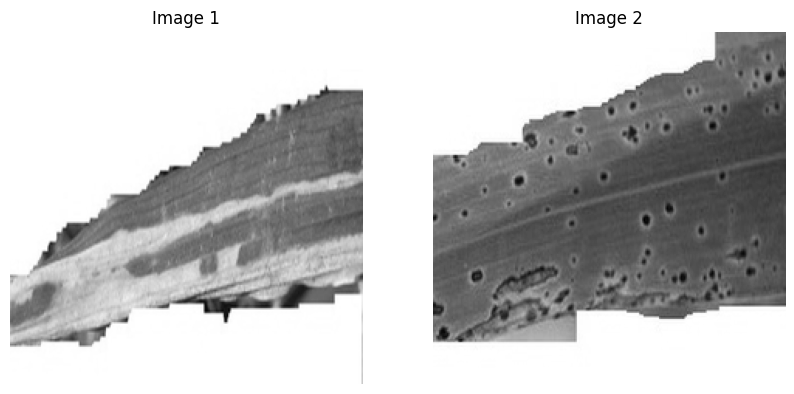

In [84]:
import matplotlib.pyplot as plt

# Assuming you have two grayscale images X[0][0][0] and X[0][1][0]
# Replace these with your actual image data
image1 = X[180][0][0]
image2 = X[180][1][0]

# Create a figure with two subplots
plt.figure(figsize=(10, 5))

# Plot the first image on the left
plt.subplot(1, 2, 1)
plt.imshow(image1, cmap='gray')
plt.title('Image 1')
plt.axis('off')

# Plot the second image on the right
plt.subplot(1, 2, 2)
plt.imshow(image2, cmap='gray')
plt.title('Image 2')
plt.axis('off')

plt.show()

In [85]:
from sklearn.model_selection import train_test_split

In [87]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.15 , stratify = Y)

In [88]:
print('x_train',x_train.shape)
print('x_test',x_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

x_train (204, 2, 1, 228, 228)
x_test (36, 2, 1, 228, 228)
y_train (204, 1)
y_test (36, 1)


In [130]:
def build_base_network(input_shape):

    seq = Sequential()

    nb_filter = [16, 32, 16]
    kernel_size = 3


    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], kernel_size, kernel_size, input_shape=input_shape,padding='valid', data_format='channels_first'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2) , data_format="channels_first"))
    seq.add(Dropout(.25))

    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], kernel_size, kernel_size, padding='valid', data_format='channels_first'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))
    seq.add(Dropout(.25))

    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[2], kernel_size, kernel_size, padding='valid', data_format='channels_first'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))
    seq.add(Dropout(.25))

    #flatten
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq

In [131]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)
print('input_dim',input_dim)

input_dim (1, 228, 228)


In [132]:
base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

In [133]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

In [134]:
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard

In [135]:
epochs = 20
rms = optimizers.legacy.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
rms = RMSprop()

earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1,
                              restore_best_weights=True)
callback_early_stop_reduceLROnPlateau=[earlyStopping]

In [136]:
model = Model(inputs=[img_a, img_b], outputs=distance)
model.compile(loss=contrastive_loss, optimizer=rms,metrics=[accuracy])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 1, 228, 228)]        0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 1, 228, 228)]        0         []                            
                                                                                                  
 sequential_4 (Sequential)   (None, 50)                   18050     ['input_13[0][0]',            
                                                                     'input_14[0][0]']            
                                                                                                  
 lambda_2 (Lambda)           (None, 1)                    0         ['sequential_4[0][0]',  

In [137]:
img_1 = x_train[:, 0]
img2 = x_train[:, 1]
img_1.shape
history = model.fit([img_1, img2], y_train, validation_split=.20,batch_size= 10, verbose=1, epochs=10, callbacks=callback_early_stop_reduceLROnPlateau)

# Option 1: Save Weights + Architecture
model.save_weights('model_weights.h5')
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())
print('saved')

Epoch 1/10


InvalidArgumentError: ignored

In [ ]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

print('Accuracy on test set: %0.2f%%' % (100 * compute_accuracy(pred, y_test)))

In [ ]:
pred = model.predict([x_train[:, 0], x_train[:, 1]])

print('* Accuracy on training set: %0.2f%%' % (100  * compute_accuracy(pred, y_train)))

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [ ]:
if resize==True:
    selected_image_size = int(selected_image_size/2)
    print('selected_image_size',selected_image_size)

In [ ]:
target_label = 1
values = np.array(y_test[:,0])

target_index = values.tolist().index(target_label)
print(target_index)
print('target_index value : ',y_test[target_index])

In [ ]:
img1 = (x_test[target_index, 0] * 255).astype(np.uint8)
img1 = img1.reshape(selected_image_size,selected_image_size)
print(img1.shape)
img1
plt.imshow(img1)
plt.show()

In [ ]:
img2 = (x_test[target_index, 1] * 255).astype(np.uint8)
img2 = img2.reshape(selected_image_size,selected_image_size)
print(img2.shape)
img2
plt.imshow(img2)
plt.show()

In [ ]:
x_test[target_index:target_index+1, 0].shape

In [ ]:
pred = model.predict([x_test[target_index:target_index+1, 0], x_test[target_index:target_index+1, 1]])
pred = pred < 0.5
print('y_test[target_index]:',y_test[target_index,0]==True,' pred :',pred)